## This code computes log-evidence of the summary statistics using trained evidence estimation network (normalizing flow), and corresponding percentiles.

### This notebook also contains code to produce Figure 5 (bottom) from the paper.

In [14]:
import sys
from pathlib import Path
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch
from torch.utils.data import DataLoader

sys.path.append('../')
from utils import datasets
import utils.resnet_cond as resnet
import utils.lightning_flows as LFlows
from utils import lightning_flows_density as LFlowsDensity


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Compute log-evidence of the summary statistics using trained evidence estimation network (normalizing flow)

In [3]:
field      = 'Mgas'
home_dir   = Path("/n/netscratch/dvorkin_lab/Lab/aakhmetzhanova/evidence-estimation-Astrid/") 
save_dir   = home_dir / f"trained_models/Maps_{field}/"

# Load summarizer.
npe_k_cond = False
n_params   = 6
summary_dim = 40

checkpoint = save_dir / f"summarizer_scale_cond_{field}_Astrid/"
checkpoint = checkpoint / "k_conv_lr_1e-4/checkpoints/best_val_loss.ckpt"
summarizer    = LFlows.LightningFlowCond.load_from_checkpoint(checkpoint, 
                                                           device=device,
                                                           k_cond='conv',
                                                           npe_k_cond=npe_k_cond,
                                                           summary_dim=summary_dim, n_params=n_params,
                                                           model_name='resnet10t.c3_in1k',).summarizer
summarizer.eval();

# Load density estimator for the summaries.
checkpoint        = save_dir / "density_summarizer_cond_Mgas_Astrid/k_context_1_lr_5e-3/".format(field)
checkpoint        = checkpoint / "checkpoints/best_val_loss.ckpt"
density_estimator = LFlowsDensity.LightningFlowDensity.load_from_checkpoint(checkpoint, 
                                                                            summarizer=summarizer, 
                                                                            summary_dim=summary_dim, 
                                                                            cond=True, 
                                                                            context=1).density_est
density_estimator.eval();


In [4]:
# Load CV maps for all sets.
minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])[:n_params] 
maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])[:n_params] 

splits    = 15
grid      = 256

set_name = 'CV' 

params_A   = np.loadtxt(home_dir / f'data/params_{set_name}_Astrid.txt',)[:, :n_params]
params_A  = (params_A - (minimum+maximum)/2)/((maximum - minimum)/2)   # rescale parameters
params_A  = np.repeat(params_A[:, None, :], splits, axis = 1) # reshape the parameters to match the shape of the maps

params_S  = np.loadtxt(home_dir / f'data/params_{set_name}_SIMBA.txt',)[:, :n_params] 
params_S  = (params_S - (minimum+maximum)/2)/((maximum - minimum)/2)   # rescale parameters
params_S  = np.repeat(params_S[:, None, :], splits, axis = 1) # reshape the parameters to match the shape of the maps

params_I   = np.loadtxt(home_dir / f'data/params_{set_name}_IllustrisTNG.txt',)[:, :n_params] 
params_I  = (params_I - (minimum+maximum)/2)/((maximum - minimum)/2)   # rescale parameters
params_I  = np.repeat(params_I[:, None, :], splits, axis = 1) # reshape the parameters to match the shape of the maps


dset_size = params_A.shape[0]
maps_A    = np.load(home_dir / f'data/2D/Maps_{field}_Astrid_{set_name}_z=0.00.npy').reshape(dset_size, -1, 1, grid, grid)[:, :splits] 
maps_S    = np.load(home_dir / f'data/2D/Maps_{field}_SIMBA_{set_name}_z=0.00.npy').reshape(dset_size, -1, 1, grid, grid)[:, :splits]
maps_I    = np.load(home_dir / f'data/2D/Maps_{field}_IllustrisTNG_{set_name}_z=0.00.npy').reshape(dset_size, -1, 1, grid, grid)[:, :splits] 

# Normalization constants
maps    = np.load(home_dir  / f'data/2D/Maps_{field}_Astrid_LH_z=0.00.npy').reshape(1000, -1, 1, grid, grid)[:, :splits]
maps_mean, maps_std = np.log10(maps).mean(), np.log10(maps).std()


In [5]:
# Smoothing scales
k_min, k_max   = 2., 45
k_smooth_array = np.logspace(np.log10(k_min), np.log10(k_max), num=10)


batch_size   = 100
seed         = 1
train_frac, valid_frac, test_frac = 0., 0., 1. # We evaluate log evidence on CV set as a whole.


In [6]:
# Compute evidence for Astrid
logE_A = []
for i, k_smooth in enumerate(k_smooth_array):
    logE_k = []
    _, _, dset = datasets.create_datasets_maps(
        maps_A, params_A, 
        train_frac, valid_frac, test_frac, 
        seed=seed, rotations=False,
        smoothing=True, k_smooth=k_smooth,
        k_min=k_min, k_max=k_max,
        normalize_k=True,
        linear=False, log_scale=True, 
        standardize=True, 
        maps_mean=maps_mean, maps_std=maps_std,
    )
    
    dataloader  = DataLoader(dset, batch_size, shuffle = False, )
    for maps, params, k in dataloader:
        with torch.no_grad():
            maps = maps.float().to(device=device)
            k    = k.float().to(device=device)
            
            summaries      = summarizer([maps, k])
            logE = density_estimator(k).log_prob(summaries).cpu().numpy()
            logE_k.append(logE)
    logE_A.append(np.concatenate(logE_k))
logE_A = np.array(logE_A)

# Compute evidence for SIMBA
logE_S = []
for i, k_smooth in enumerate(k_smooth_array):
    logE_k = []
    _, _, dset = datasets.create_datasets_maps(maps_S, params_S, 
                                                   train_frac, valid_frac, test_frac, 
                                                   seed=seed, rotations=False, 
                                                   smoothing=True, k_smooth=k_smooth,
                                                   k_min=k_min, k_max=k_max,
                                                   normalize_k=True,
                                                   linear=False, log_scale=True, 
                                                   standardize=True, 
                                                   maps_mean=maps_mean, maps_std=maps_std,)
    dataloader  = DataLoader(dset, batch_size, shuffle = False, )
    for maps, params, k in dataloader:
        with torch.no_grad():
            maps = maps.float().to(device=device)
            k    = k.float().to(device=device)
            
            summaries      = summarizer([maps, k])
            logE = density_estimator(k).log_prob(summaries).cpu().numpy()
            logE_k.append(logE)
    logE_S.append(np.concatenate(logE_k))
logE_S = np.array(logE_S)


# Compute evidence for IllustrisTNG
logE_I = []
for i, k_smooth in enumerate(k_smooth_array):
    logE_k = []
    _, _, dset = datasets.create_datasets_maps(maps_I, params_I, 
                                                   train_frac, valid_frac, test_frac, 
                                                   seed=seed, rotations=False, 
                                                   smoothing=True, k_smooth=k_smooth,
                                                   k_min=k_min, k_max=k_max+1e-2,
                                                   normalize_k=True,
                                                   linear=False, log_scale=True, 
                                                   standardize=True, 
                                                   maps_mean=maps_mean, maps_std=maps_std,)
    dataloader  = DataLoader(dset, batch_size, shuffle = False, )
    for maps, params, k in dataloader:
        with torch.no_grad():
            maps = maps.float().to(device=device)
            k    = k.float().to(device=device)
            
            summaries      = summarizer([maps, k])
            logE = density_estimator(k).log_prob(summaries).cpu().numpy()
            logE_k.append(logE)
    logE_I.append(np.concatenate(logE_k))
logE_I = np.array(logE_I)

# Save results for plotting.
results_dir = Path("results/")
np.save(results_dir / '{:s}_log_evidence_SIMBA_CV.npy'.format(field), logE_S)
np.save(results_dir / '{:s}_log_evidence_Astrid_CV.npy'.format(field), logE_A)
np.save(results_dir / '{:s}_log_evidence_IllustrisTNG_CV.npy'.format(field), logE_I)

In [9]:
# Compute percentiles of SIMBA and IllustrisTNG wrt Astrid CV set
percentile_S, percentile_I = [], []
for i, k_smooth in enumerate(k_smooth_array):
    percentile_S.append(np.array([stats.percentileofscore(logE_A[i], logE) for logE in logE_S[i]]))
    percentile_I.append(np.array([stats.percentileofscore(logE_A[i], logE) for logE in logE_I[i]]))

percentile_S = np.array(percentile_S)
percentile_I = np.array(percentile_I)

# Compute percentiles of fields from Astrid CV set with leave-one-out approach
percentile_A = []
for i, k_smooth in enumerate(k_smooth_array):
    percentile_A_k = []
    for j in range(dset_size):
        logE_A_temp = np.delete(logE_A[i], j)
        percentile_A_k.append(stats.percentileofscore(logE_A_temp, logE_A[i][j]))
    percentile_A.append(np.array(percentile_A_k))
percentile_A = np.array(percentile_A)

# Save results for plotting.
results_dir = Path("results/")
np.save(results_dir / f'{field}_log_evidence_percentile_Astrid_CV.npy', percentile_A)
np.save(results_dir / f'{field}_log_evidence_percentile_SIMBA_CV.npy', percentile_S)
np.save(results_dir / f'{field}_log_evidence_percentile_IllustrisTNG_CV.npy', percentile_I)

### Plot histograms of log-evidence values for different scales (with offsets for visual separation)

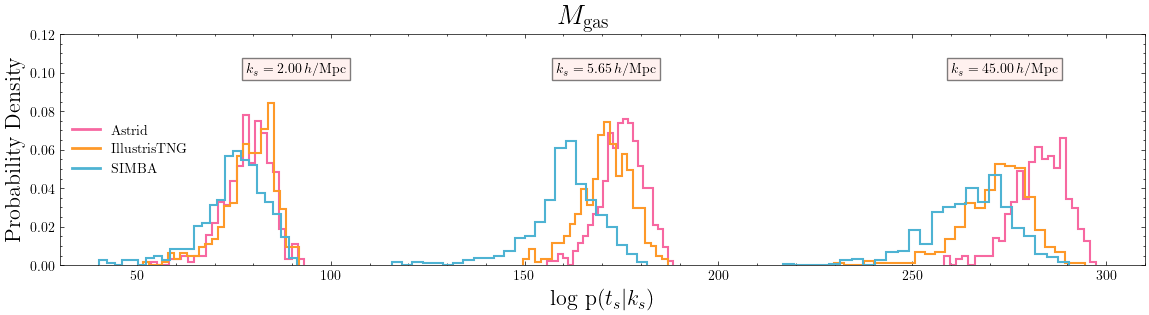

In [16]:
plt.style.use(['science'])

f, ax = plt.subplots(1, 1, sharey=True, figsize=(14, 3))
f.suptitle(r'$M_{\mathrm{gas}}$', fontsize=20)
colors  = ['#f768a1', '#fe9929', '#4eb3d3',]
lstyles = ['dashdot', 'dashed', 'solid']
offsets = [0, 110, 220]
k_idxs  = [0, 3, 9]
n_bins  = 25

for i, k_idx in enumerate(k_idxs):
    ax.hist(logE_A[k_idx] + offsets[i], bins=n_bins, 
            ec=colors[0], fc='none', lw=1.5, histtype='step', density=True,
           )
    ax.hist(logE_I[k_idx] + offsets[i], bins=n_bins,
            ec=colors[1], fc='none', lw=1.5, histtype='step', density=True,
           )
    ax.hist(logE_S[k_idx] + offsets[i], bins=n_bins, 
            ec=colors[2], fc='none', lw=1.5, histtype='step', density=True,
           )    

custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[2], lw=2),]

ax.legend(custom_lines, ['Astrid', 'IllustrisTNG', 'SIMBA',], loc='center left')

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='square', facecolor='mistyrose', alpha=0.5)
ax.text(78, 0.1, r'$ k_s ={:.2f} \, h/$'.format(k_smooth_array[k_idxs[0]])+r'$\mathrm{Mpc}$',
        bbox=props)
ax.text(158, 0.1, r'$ k_s ={:.2f} \, h/$'.format(k_smooth_array[k_idxs[1]])+r'$\mathrm{Mpc}$',
        bbox=props)
ax.text(260, 0.1, r'$ k_s ={:.2f} \, h/$'.format(k_smooth_array[k_idxs[2]])+r'$\mathrm{Mpc}$',
       bbox=props)

ax.set_ylabel('Probability Density', fontsize=16)
ax.set_xlabel('log p' + r'$(t_s|k_{s})$', fontsize=16)
ax.set_xlim(30, 310)
ax.set_ylim(0., 0.12)
plt.savefig(f'plots/3_evidence_{field}_single_plot.pdf')
f.show()

### Additional Plots

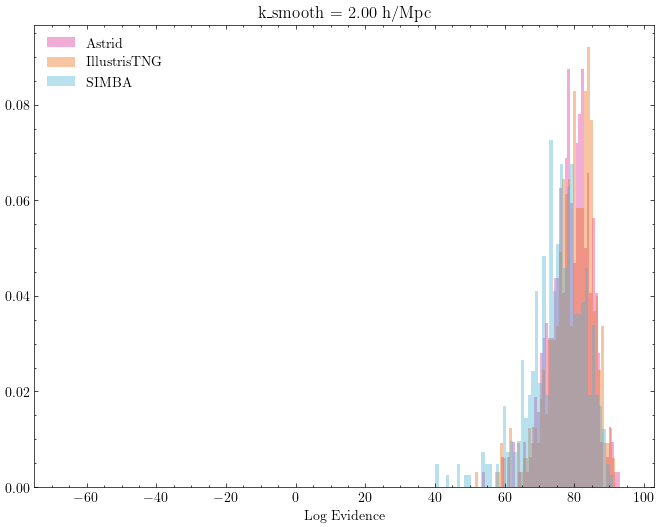

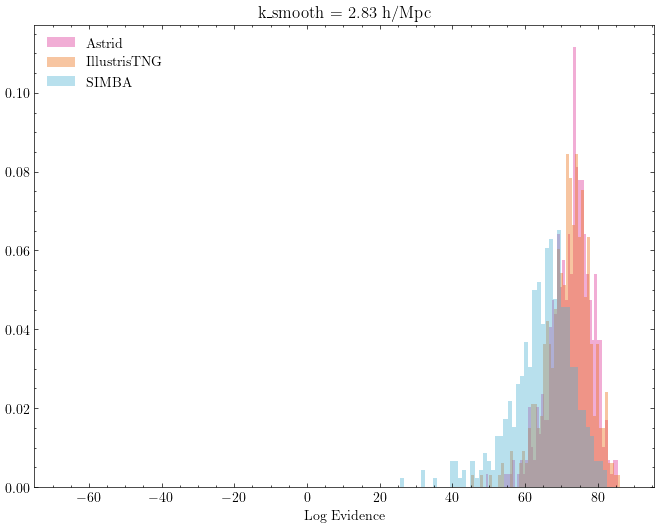

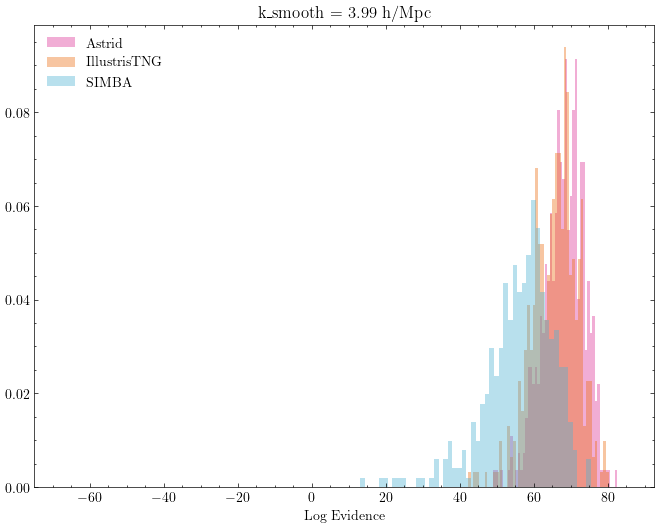

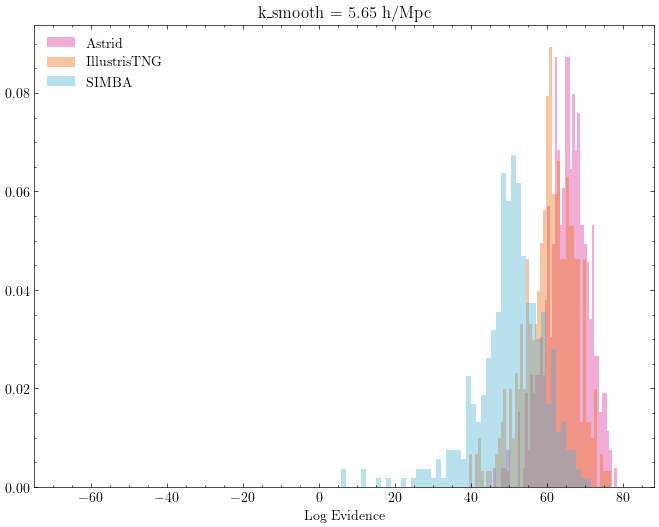

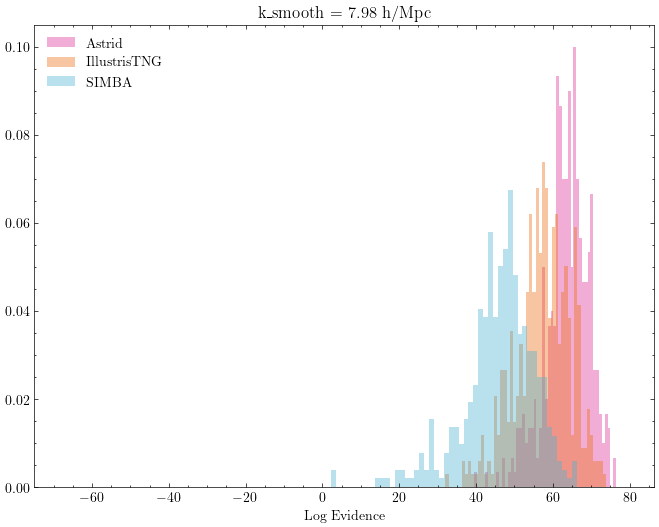

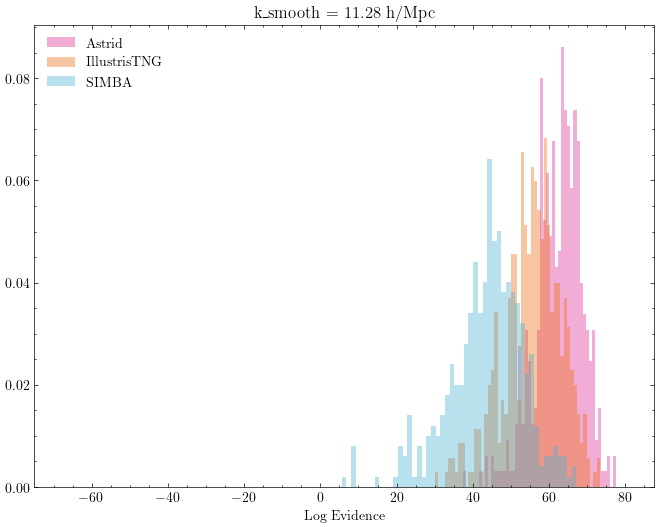

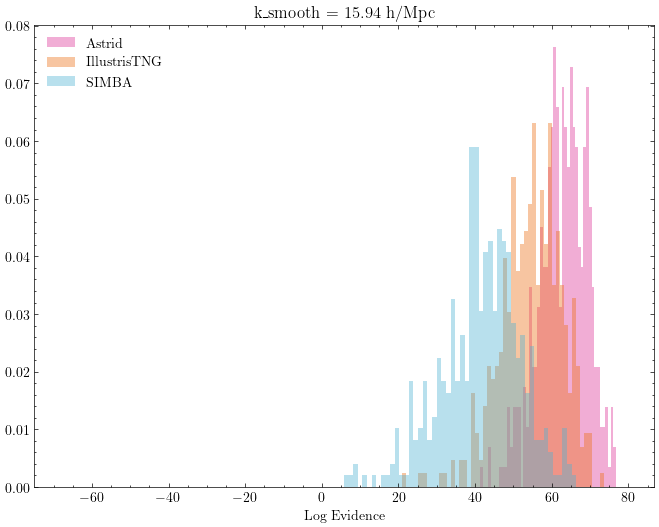

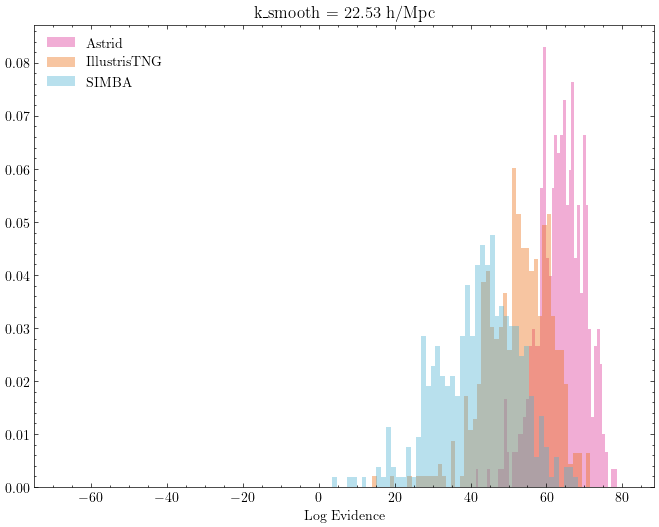

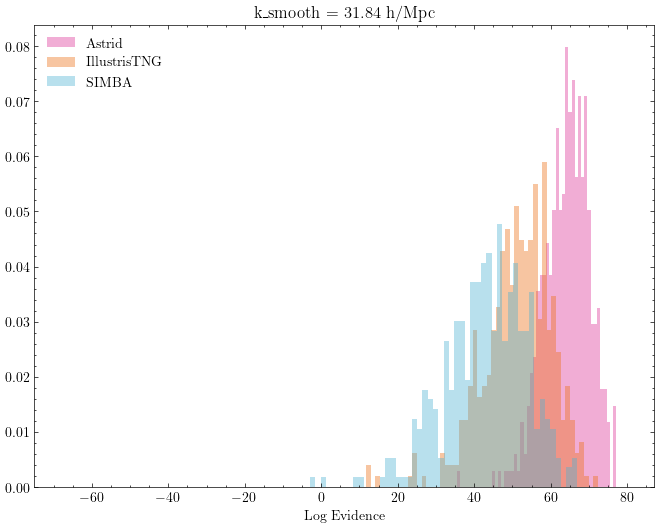

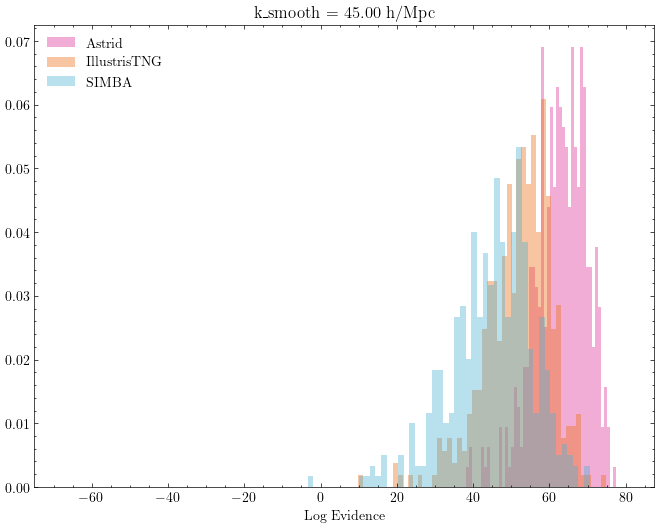

In [10]:
# Visualize distribution of log-evidence values for different smoothing scales.

plt.style.use(['science'])

alpha = 0.4
n_bins  = 50
density = True

colors = ['#dd3497', '#ec7014', '#4eb3d3', ]#['palevioletred', 'chocolate', 'steelblue']

for i in range(len(k_smooth_array)):
    k_smooth = k_smooth_array[i]
    plt.figure(i, figsize=(8, 6))
    plt.title(f'k_smooth = {k_smooth:.2f} h/Mpc')
    plt.xlabel('Log Evidence')
    plt.xlim(-75, logE_A[i].max() + 10)
    counts, bins, _ = plt.hist(logE_A[i], bins=n_bins, alpha = alpha, density = density, 
             label='Astrid', color=colors[0])
    plt.hist(logE_I[i], bins=n_bins, alpha = alpha, density = density, 
             label='IllustrisTNG', color=colors[1])
    plt.hist(logE_S[i], bins=n_bins, alpha = alpha, density = density, 
             label='SIMBA', color=colors[2])
    plt.legend(loc='best')
    

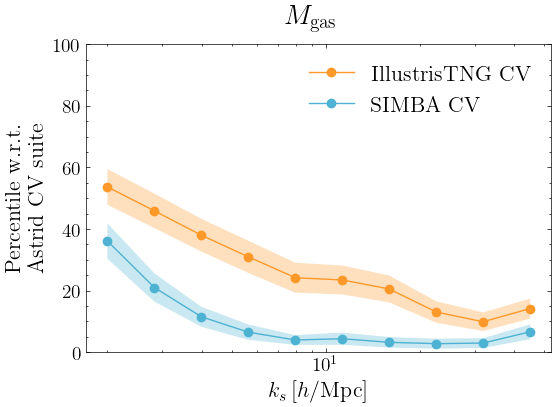

In [12]:
colors = ['#f768a1', '#fe9929', '#4eb3d3', ]

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))
f.suptitle(r'$M_{\mathrm{gas}}$', fontsize=20)

ax1.plot(k_smooth_array, percentile_I.mean(axis=1),c=colors[1], marker='o', label='IllustrisTNG CV' )
ax1.fill_between(k_smooth_array,  
                 percentile_I.mean(axis=1) + percentile_I.std(axis=1)/np.sqrt(dset_size),
                 percentile_I.mean(axis=1) - percentile_I.std(axis=1)/np.sqrt(dset_size), 
                 facecolor=colors[1], alpha=0.3,)

ax1.plot(k_smooth_array, percentile_S.mean(axis=1), c=colors[2], marker='o', label='SIMBA CV')
ax1.fill_between(k_smooth_array, 
                 percentile_S.mean(axis=1) + percentile_S.std(axis=1)/np.sqrt(dset_size), 
                 percentile_S.mean(axis=1) - percentile_S.std(axis=1)/np.sqrt(dset_size),
                 facecolor=colors[2], alpha=0.3,)

ax1.set_ylabel('Percentile w.r.t. \n Astrid CV suite', fontsize=16)
ax1.set_xlabel(r'$ k_s \, [h/\mathrm{Mpc}]$', fontsize=16)
ax1.set_ylim(0, 100)
ax1.set_xscale('log')
ax1.legend(loc='best', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
